In [342]:
# Import modules

import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import pandas as pd
from random import random
from matplotlib import pyplot as plt
import warnings
from sklearn.metrics import mean_squared_error
from pdb import set_trace as keyboard

In [343]:
# Importing the csv file first and print a summary
# Edit this part##################################
State_abbrv = 'WI'
##################################################

In [344]:
# Code based on https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        #print(model_fit.summary())
        yhat = model_fit.forecast(1,alpha=0.05)[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    #keyboard()
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    return best_cfg

In [345]:
filename = './' + State_abbrv + '_EV_sales_data_final.csv'
filename2 = './' + State_abbrv + '_Exogenous_ARIMA_prediction_data.csv'
State_df = pd.read_csv(filename)
State_df.info()
State_df.head()
State_df.keys()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 8 non-null      int64  
 1   Unnamed: 0.1               8 non-null      int64  
 2   Year                       8 non-null      int64  
 3   BEV sales                  8 non-null      int64  
 4   PHEV sales                 8 non-null      int64  
 5   Total                      8 non-null      int64  
 6   Gasoline Price             8 non-null      float64
 7   Median Income              8 non-null      int64  
 8   Population                 8 non-null      int64  
 9   Renewable Energy Use       8 non-null      int64  
 10  Total Energy Use           8 non-null      int64  
 11  Transportation Energy Use  8 non-null      int64  
 12  Stations Opened            8 non-null      float64
 13  Lithium Price              8 non-null      int64  
dty

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Year', 'BEV sales', 'PHEV sales',
       'Total', 'Gasoline Price', 'Median Income', 'Population',
       'Renewable Energy Use', 'Total Energy Use', 'Transportation Energy Use',
       'Stations Opened', 'Lithium Price'],
      dtype='object')

In [346]:
# Cleanup columns and set date as index

State_df = State_df.drop(columns=['Unnamed: 0','Unnamed: 0.1'])
State_df['Year'] = pd.to_datetime(State_df.Year, format='%Y')
State_df.set_index('Year',inplace=True)
State_df.rename(columns={'Gasoline Price':'Gasoline_Price','Median Income':'Median_Income','Lithium Price':'Lithium_Price'},inplace=True)

In [347]:
State_df.head()

,BEV sales,PHEV sales,Total,Gasoline_Price,Median_Income,Population,Renewable Energy Use,Total Energy Use,Transportation Energy Use,Stations Opened,Lithium_Price
Year,,,,,,,,,,,
2011-01-01,2,91,93,3.496,31766,5705840,208301,68612,420456,27.0,946
2012-01-01,98,538,636,3.566,33308,5720825,199588,68820,418959,45.0,744
2013-01-01,207,416,623,3.468,31133,5738012,206192,69124,416071,15.0,684
2014-01-01,191,435,626,3.303,30711,5753199,216236,69495,445797,38.0,606
2015-01-01,693,290,983,2.339,29123,5762927,223327,68699,440631,50.0,393


# Gasoline price

Text(0.5, 0, 'Year')

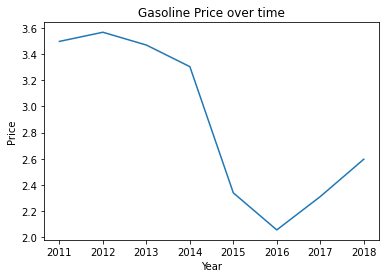

In [348]:
# Plot the time series

plt.figure(0)
plt.plot(State_df.Gasoline_Price)
plt.title('Gasoline Price over time')
plt.ylabel('Price')
plt.xlabel('Year')

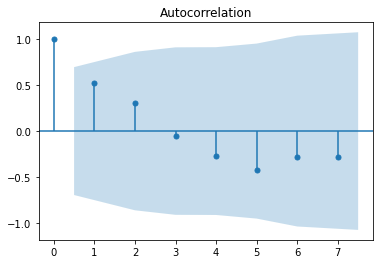

In [349]:
# Plot ACF
# Anything within the blue bars is statistically insignificant

acf_plot = plot_acf(State_df.Total)

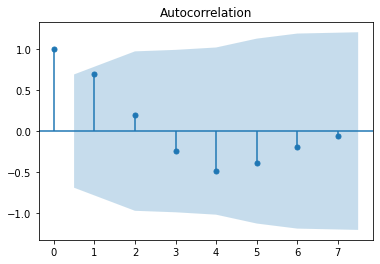

In [350]:
# Plot PACF
# Anything within the blue bars is statistically insignificant

pacf_plot = plot_acf(State_df.Gasoline_Price)

In [351]:
# Perform ADF test to check if time series is stationary
result = adfuller(State_df['Gasoline_Price'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.014330
p-value: 0.748002


In [352]:
# Find optimal (p,d,q)
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)

warnings.filterwarnings("ignore")
best_cfg_GP = evaluate_models(State_df['Gasoline_Price'].values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=0.823
ARIMA(0, 0, 1) RMSE=0.464
ARIMA(0, 0, 2) RMSE=0.604
ARIMA(0, 1, 0) RMSE=0.275
ARIMA(0, 1, 1) RMSE=0.183
ARIMA(0, 1, 2) RMSE=0.365
ARIMA(0, 2, 0) RMSE=0.501
ARIMA(0, 2, 1) RMSE=0.656
ARIMA(0, 2, 2) RMSE=0.873
ARIMA(1, 0, 0) RMSE=0.482
ARIMA(1, 0, 1) RMSE=0.403
ARIMA(1, 0, 2) RMSE=0.462
ARIMA(1, 1, 0) RMSE=0.275
ARIMA(1, 1, 1) RMSE=0.298
ARIMA(1, 1, 2) RMSE=0.283
ARIMA(1, 2, 0) RMSE=0.734
ARIMA(1, 2, 1) RMSE=0.759
ARIMA(1, 2, 2) RMSE=0.742
ARIMA(2, 0, 0) RMSE=0.217
ARIMA(2, 0, 1) RMSE=0.222
ARIMA(2, 0, 2) RMSE=0.271
ARIMA(2, 1, 0) RMSE=0.298
ARIMA(2, 1, 1) RMSE=0.334
ARIMA(2, 1, 2) RMSE=0.313
ARIMA(2, 2, 0) RMSE=0.763
ARIMA(2, 2, 1) RMSE=0.731
ARIMA(2, 2, 2) RMSE=0.706
Best ARIMA(0, 1, 1) RMSE=0.183


In [353]:
p = best_cfg_GP[0]
d = best_cfg_GP[1]
q = best_cfg_GP[2]
#print(state_df['Total'].size)
#print(state_df['Gasoline Price'].size)
ARIMA_GP_model = ARIMA(State_df['Gasoline_Price'],order=(p,d,q))
ARIMA_GP_model_fit = ARIMA_GP_model.fit()
print(ARIMA_GP_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         Gasoline_Price   No. Observations:                    8
Model:                 ARIMA(0, 1, 1)   Log Likelihood                  -3.091
Date:                Fri, 01 Apr 2022   AIC                             10.181
Time:                        16:27:06   BIC                             10.073
Sample:                    01-01-2011   HQIC                             8.844
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4319      0.930      0.465      0.642      -1.390       2.254
sigma2         0.1375      0.055      2.508      0.012       0.030       0.245
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [354]:
# Forecast
pred_GP = ARIMA_GP_model_fit.forecast(15, alpha=0.05)  # 95% conf

In [355]:
Exog_df = pd.DataFrame(pred_GP)
Exog_df.rename(columns={'predicted_mean':'Gasoline_Price_predicted'},inplace=True)

# Median Household Income

Text(0.5, 0, 'Year')

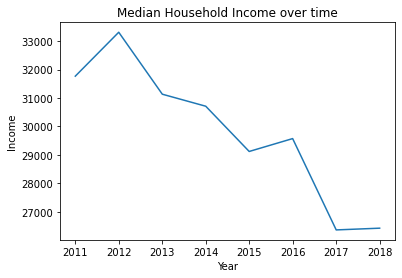

In [356]:
# Plot the time series

plt.figure(0)
plt.plot(State_df.Median_Income)
plt.title('Median Household Income over time')
plt.ylabel('Income')
plt.xlabel('Year')

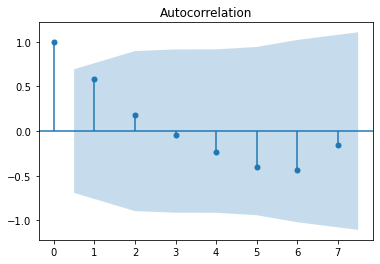

In [357]:
# Plot ACF
# Anything within the blue bars is statistically insignificant

acf_plot = plot_acf(State_df.Median_Income)

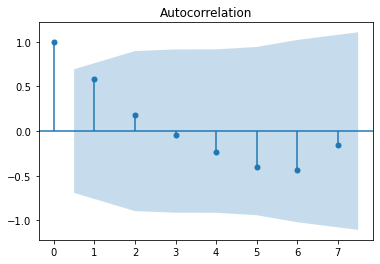

In [358]:
# Plot PACF
# Anything within the blue bars is statistically insignificant

pacf_plot = plot_acf(State_df.Median_Income)

In [359]:
# Perform ADF test to check if time series is stationary
result = adfuller(State_df['Median_Income'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.778414
p-value: 0.991280


In [360]:
# Find best (p,d,q)

warnings.filterwarnings("ignore")
best_cfg_MI = evaluate_models(State_df['Median_Income'].values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=3576.538
ARIMA(0, 0, 1) RMSE=2887.794
ARIMA(0, 0, 2) RMSE=2218.079
ARIMA(0, 1, 0) RMSE=1869.622
ARIMA(0, 1, 1) RMSE=1918.472
ARIMA(0, 1, 2) RMSE=2155.339
ARIMA(0, 2, 0) RMSE=3066.804
ARIMA(0, 2, 1) RMSE=3484.815
ARIMA(0, 2, 2) RMSE=3402.277
ARIMA(1, 0, 0) RMSE=2420.149
ARIMA(1, 0, 1) RMSE=2628.406
ARIMA(1, 0, 2) RMSE=2593.361
ARIMA(1, 1, 0) RMSE=1901.100
ARIMA(1, 1, 1) RMSE=1408.426
ARIMA(1, 1, 2) RMSE=2191.139
ARIMA(1, 2, 0) RMSE=3396.225
ARIMA(1, 2, 1) RMSE=2270.916
ARIMA(1, 2, 2) RMSE=2827.618
ARIMA(2, 0, 0) RMSE=2799.787
ARIMA(2, 0, 1) RMSE=3392.570
ARIMA(2, 0, 2) RMSE=2725.888
ARIMA(2, 1, 0) RMSE=2062.326
ARIMA(2, 1, 1) RMSE=1215.547
ARIMA(2, 1, 2) RMSE=1852.847
ARIMA(2, 2, 0) RMSE=3275.139
ARIMA(2, 2, 2) RMSE=2268.902
Best ARIMA(2, 1, 1) RMSE=1215.547


In [361]:
p = best_cfg_MI[0]
d = best_cfg_MI[1]
q = best_cfg_MI[2]

ARIMA_MI_model = ARIMA(State_df['Median_Income'],order=(p,d,q))
ARIMA_MI_model_fit = ARIMA_MI_model.fit()
print(ARIMA_MI_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:          Median_Income   No. Observations:                    8
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 -60.030
Date:                Fri, 01 Apr 2022   AIC                            128.060
Time:                        16:27:21   BIC                            127.844
Sample:                    01-01-2011   HQIC                           125.386
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9869      0.184      5.376      0.000       0.627       1.347
ar.L2         -0.1126      0.134     -0.840      0.401      -0.375       0.150
ma.L1         -1.0000      0.788     -1.268      0.2

In [362]:
# Forecast
pred_MI = ARIMA_MI_model_fit.forecast(15, alpha=0.05)  # 95% conf

In [363]:
Exog_df = pd.concat([Exog_df,pd.DataFrame(pred_MI)], axis=1)
Exog_df.rename(columns={'predicted_mean':'Median_Income_predicted'},inplace=True)
Exog_df.head()

,Gasoline_Price_predicted,Median_Income_predicted
2019-01-01,2.68054,25865.984046
2020-01-01,2.68054,25302.510800
2021-01-01,2.68054,24809.962845
2022-01-01,2.68054,24387.346929
2023-01-01,2.68054,24025.756316


# Lithium Price

Text(0.5, 0, 'Year')

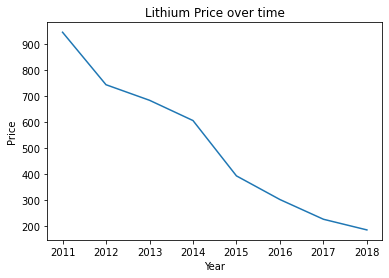

In [364]:
# Plot the time series

plt.figure(0)
plt.plot(State_df.Lithium_Price)
plt.title('Lithium Price over time')
plt.ylabel('Price')
plt.xlabel('Year')

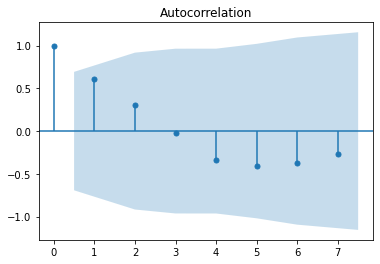

In [365]:
# Plot ACF
# Anything within the blue bars is statistically insignificant

acf_plot = plot_acf(State_df.Lithium_Price)

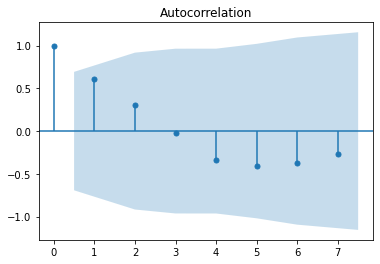

In [366]:
# Plot PACF
# Anything within the blue bars is statistically insignificant

pacf_plot = plot_acf(State_df.Lithium_Price)

In [367]:
# Perform ADF test to check if time series is stationary
result = adfuller(State_df['Lithium_Price'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.563256
p-value: 0.502020


In [368]:
# Find best (p,d,q)

warnings.filterwarnings("ignore")
best_cfg_LI = evaluate_models(State_df['Lithium_Price'].values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=377.187
ARIMA(0, 0, 1) RMSE=216.340
ARIMA(0, 0, 2) RMSE=137.244
ARIMA(0, 1, 0) RMSE=72.429
ARIMA(0, 1, 1) RMSE=55.119
ARIMA(0, 1, 2) RMSE=80.052
ARIMA(0, 2, 0) RMSE=73.788
ARIMA(0, 2, 1) RMSE=60.008
ARIMA(0, 2, 2) RMSE=91.748
ARIMA(1, 0, 0) RMSE=130.641
ARIMA(1, 0, 1) RMSE=75.847
ARIMA(1, 0, 2) RMSE=106.379
ARIMA(1, 1, 0) RMSE=43.163
ARIMA(1, 1, 1) RMSE=92.764
ARIMA(1, 1, 2) RMSE=90.190
ARIMA(1, 2, 0) RMSE=77.513
ARIMA(1, 2, 1) RMSE=46.740
ARIMA(1, 2, 2) RMSE=76.585
ARIMA(2, 0, 0) RMSE=60.136
ARIMA(2, 0, 1) RMSE=175.554
ARIMA(2, 0, 2) RMSE=59.522
ARIMA(2, 1, 0) RMSE=46.176
ARIMA(2, 1, 1) RMSE=72.065
ARIMA(2, 1, 2) RMSE=82.292
ARIMA(2, 2, 0) RMSE=103.044
ARIMA(2, 2, 1) RMSE=90.805
ARIMA(2, 2, 2) RMSE=107.349
Best ARIMA(1, 1, 0) RMSE=43.163


In [369]:
p = best_cfg_LI[0]
d = best_cfg_LI[1]
q = best_cfg_LI[2]

ARIMA_LP_model = ARIMA(State_df['Lithium_Price'],order=(p,d,q))
ARIMA_LP_model_fit = ARIMA_LP_model.fit()
print(ARIMA_LP_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:          Lithium_Price   No. Observations:                    8
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -41.958
Date:                Fri, 01 Apr 2022   AIC                             87.916
Time:                        16:27:38   BIC                             87.808
Sample:                    01-01-2011   HQIC                            86.579
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7125      0.357      1.993      0.046       0.012       1.413
sigma2      8167.6472   6864.981      1.190      0.234   -5287.469    2.16e+04
Ljung-Box (L1) (Q):                   1.87   Jarque-

In [370]:
# Forecast
pred_LP = ARIMA_LP_model_fit.forecast(15, alpha=0.05)  # 95% conf

In [371]:
Exog_df = pd.concat([Exog_df,pd.DataFrame(pred_LP)], axis=1)
Exog_df.rename(columns={'predicted_mean':'Lithium_Price_predicted'},inplace=True)
Exog_df.head()

,Gasoline_Price_predicted,Median_Income_predicted,Lithium_Price_predicted
2019-01-01,2.68054,25865.984046,155.785845
2020-01-01,2.68054,25302.510800,134.969580
2021-01-01,2.68054,24809.962845,120.137152
2022-01-01,2.68054,24387.346929,109.568447
2023-01-01,2.68054,24025.756316,102.037819


In [372]:
Exog_df.to_csv(filename2)